In [26]:
import numpy as np
import imageio as iio
import DatasetSplitter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as pca_test


# Splitting images to training data and testing data

In [2]:
trainingData, trainingLabels, testingData, testingLabels = DatasetSplitter.splitData()

# Computing covariance matrix

In [3]:
def covariance(D):
    global mean_vector 
    mean_vector = np.mean(D, axis=0)
    Z = D - mean_vector
    cov = (1/len(D)) * (Z.T @ Z) 
    return cov


In [4]:
# try
# def covariance(D):
#     global mean_vector 
#     mean_vector = np.mean(D, axis=0)
#     global Z 
#     Z = D - mean_vector
#     cov = (1/len(D))*(Z @ Z.T) 
#     return cov

# Testing computational correctness of covariance matrix

In [5]:
# Test cov matrix 
trainingData = np.array(trainingData)
myCov = covariance(trainingData)
numCov = np.cov(trainingData.T, bias=True)
# print(numCov)

# Applying PCA algorithm to obtain P -> projection matrix

In [6]:
def PCA(D, alpha):
    cov = covariance(D)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    sorted_idx = eigenvalues.argsort()[::-1]  # Sort in descending order
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    
    trace = np.trace(cov)
    c = 0 # Accumulator for sum of eigenvaleus
    lastIndex = 0
    for index in range(len(eigenvalues)):
        c += eigenvalues[index]
        if c / trace >= alpha :
            lastIndex = index
            break
    P = eigenvectors[:lastIndex + 1, :]# Projection Matrix
    return P

In [7]:
# # try
# def PCA(D, alpha):
#     cov = covariance(D)
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
#     sorted_idx = eigenvalues.argsort()[::-1]  # Sort in descending order
#     eigenvalues = eigenvalues[sorted_idx]
#     eigenvectors = eigenvectors[:, sorted_idx]
    
#     eigenvectors = Z.T @ eigenvectors
    
#     eigenvectors = eigenvectors.T/ np.sqrt((eigenvectors.T ** 2).sum(axis=1, keepdims=True))
    
#     trace = sum(eigenvalues)
#     c = 0 # Accumulator for sum of eigenvaleus
#     lastIndex = 0
#     for index in range(len(eigenvalues)):
#         c += eigenvalues[index]
#         if c / trace >= alpha :
#             lastIndex = index
#             break
#     P = eigenvectors[:lastIndex + 1, :]# Projection Matrix
#     return P

In [8]:
def projectData(trainData, testData, alpha):
    P = PCA(trainData, alpha)
    # Project training data (correctly subtract mean before projection)
    projectedTrainingData = (trainData - mean_vector) @ P.T

    # Project testing data (correctly subtract mean before projection)
    projectedTestingData = (testData - mean_vector) @ P.T
    
    return projectedTrainingData, projectedTestingData

# Using KNN classifier, tie breaking at distance strategy

In [9]:
def classifyKNN(projectedTrainData, trainLabel, projectedTestData, testLabel, k):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(projectedTrainData, trainLabel)
    # Calc accuracy of clssification
    predictedClasses = knn.predict(projectedTestData)
    accuracy = accuracy_score(testLabel, predictedClasses)
    print(f"Accuracy {100 * (accuracy)}")
    return accuracy

# Main Flow

In [10]:
alpha_list = np.array([0.8, 0.85, 0.9, 0.95])
accuracy_results = np.array([])
k = 1
for alpha in alpha_list:
    # Train the model
    projectedTrainingData, projectedTestingData = projectData(trainingData, testingData, alpha)
    # Classify and test
    accuracy_results = np.append(accuracy_results, classifyKNN(
        projectedTrainingData, trainingLabels, 
        projectedTestingData, testingLabels,
        k
    ))
      

Accuracy 70.5
Accuracy 82.5
Accuracy 86.0
Accuracy 91.5


In [11]:
# Deep copy of results as it'll be used later
accuracyOfEqualSplit = np.array(accuracy_results)   

# Plot the results

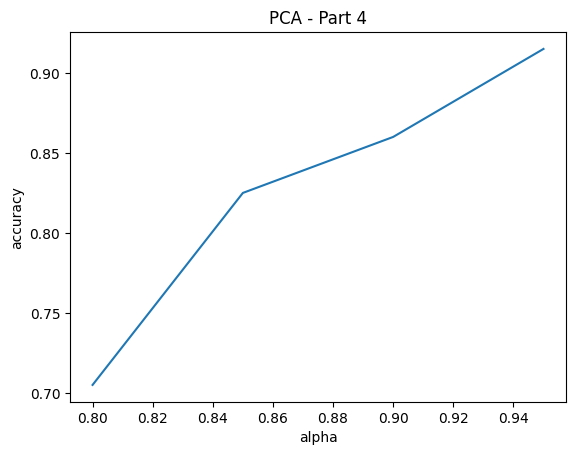

In [12]:
# plotting the points 
plt.plot(alpha_list, accuracy_results)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('PCA - Part 4')
plt.show()  

According to this plot, accuracy is proportional to alpha. 

# Hyper-parameter tuning

In [13]:
k_list = np.array([1, 3, 5, 7])
accuracy_results = np.array([])
alpha = 0.95
for k in k_list:
    # Train the model
    projectedTrainingData, projectedTestingData = projectData(trainingData, testingData, alpha)
    # Classify and test
    accuracy_results = np.append(accuracy_results, classifyKNN(
        projectedTrainingData, trainingLabels, 
        projectedTestingData, testingLabels,
        k
    ))

Accuracy 91.5
Accuracy 86.0
Accuracy 78.5
Accuracy 76.0


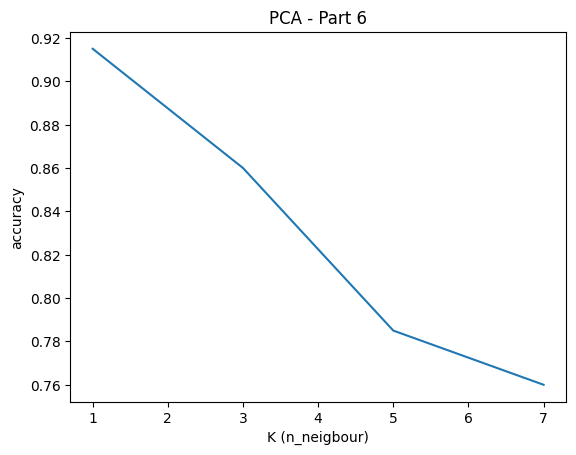

In [14]:
# plotting the points 
plt.plot(k_list, accuracy_results)
plt.xlabel('K (n_neigbour)')
plt.ylabel('accuracy')
plt.title('PCA - Part 6')
plt.show()  

In our case the best K is K = 1 

# Bonus

# Using randomized PCA for fast computation 

The time complexity of randomized PCA is O(n * p^2) + O(p^3) where p is the number of PCs. Meanwhile, The time complexity of traditional PCA is O(n * d^2) + O(d^3)

In [15]:
k = 1
numPca = pca_test(n_components=114, svd_solver='randomized')
transformedTrainingData = numPca.fit_transform(trainingData)
transformedTestingData = numPca.transform(testingData)
accuracy = classifyKNN(
        transformedTrainingData, trainingLabels, 
        transformedTestingData, testingLabels,
        k
    )
print(f"Randomized PCA at K = 1")


Accuracy 93.0
Randomized PCA at K = 1


The accuracy is better than mine but In general it's less than the traditional PCA.

The reason why our PCA is less better tha pyhon's one is the propagation error (truncation error) at calculating the covariance matrix

# Using different split of data (70% for training - 30 %  for testing)

In [16]:
trainingData, trainingLabels, testingData, testingLabels = DatasetSplitter.differentSplitData()

In [17]:
alpha_list = np.array([0.8, 0.85, 0.9, 0.95])
accuracy_results = np.array([])
k = 1
for alpha in alpha_list:
    # Train the model
    projectedTrainingData, projectedTestingData = projectData(trainingData, testingData, alpha)
    # Classify and test
    accuracy_results = np.append(accuracy_results, classifyKNN(
        projectedTrainingData, trainingLabels, 
        projectedTestingData, testingLabels,
        k
    ))

Accuracy 74.16666666666667
Accuracy 88.33333333333333
Accuracy 94.16666666666667
Accuracy 95.83333333333334


# Plot the results

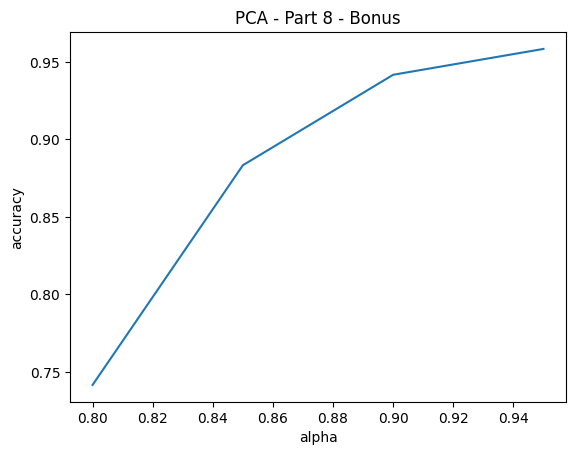

In [18]:
# plotting the points 
plt.plot(alpha_list, accuracy_results)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('PCA - Part 8 - Bonus')
plt.show() 

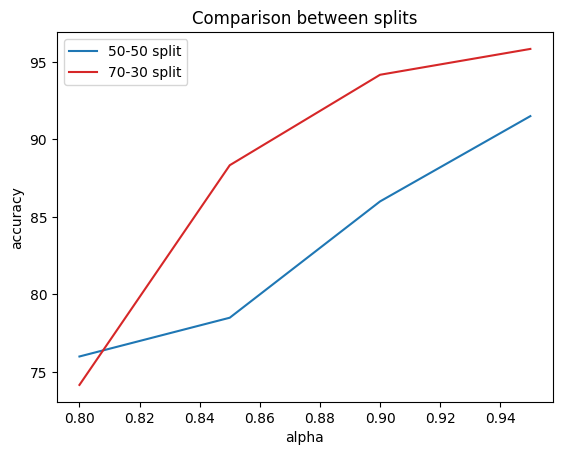

In [19]:
alpha_list = np.array([0.8, 0.85, 0.9, 0.95])
accuracyOfEqualSplit = np.array([76.0, 78.5, 86.0, 91.5])
accuracyOfDifferentSplit = np.array([74.16666666666667, 88.33333333333333, 94.16666666666667, 95.83333333333334])

fig, ax = plt.subplots()

# Plot both lines on the same axes
ax.plot(alpha_list, accuracyOfEqualSplit, color='tab:blue', label='50-50 split')
ax.plot(alpha_list, accuracyOfDifferentSplit, color='tab:red', label='70-30 split')

# Set labels and title
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
plt.title('Comparison between splits')

# Add a legend
ax.legend()

plt.show()


# Dual PCA

Theoretically, basic PCA and Dual PCA have similar accuracy. In practice, if the number of samples (n) is much smaller than the number of dimensions (d), Dual PCA is more computationally efficient. 

However, if n is larger than or equal to d, basic PCA is more efficient and avoids potential issues with finding inverse of singular values diagonal matrix.

Time complexity of basic PCA : O(n * d^2) + O(d^3) -> Z.T @ Z, eig(cov)


Time complexity of dual PCA : O(d * n^2) + O(n^3)  -> Z @ Z.T, svd(cov)


other terms are order of r (reduced dimensions) so it's negligible.

Calculate the scatter-matrix to make use of singular value decomposition (SVD)

In [21]:
def covariance(D):
    global mean_vector 
    mean_vector = np.mean(D, axis=0)
    Z = D - mean_vector 
    cov = (Z @ Z.T) 
    return cov

# Dual PCA implementation

In [22]:
def DualPCA(D, testingData, alpha): # D is n x d
    cov = covariance(D)
    global eigenvectors, eigenvalues, eigenvectorsTranspose                # U -> n x rank
    eigenvectors, eigenvalues, eigenvectorsTranspose = np.linalg.svd(cov) # With resc pect to Z @ Z.T
    eigenvalues = np.sqrt(eigenvalues) # Sigma
    
    sorted_idx = eigenvalues.argsort()[::-1]  # Sort in descending order
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    
    # Project training Data Z . V = U . Sigma
    trace = sum(eigenvalues)
    
    c = 0 # Accumulator for sum of eigenvaleus
    lastIndex = 0
    for index in range(len(eigenvalues)):
        c += eigenvalues[index]
        if c / trace >= alpha :
            lastIndex = index
            break
        
    # r -> reduced    
    Ur = eigenvectors[:, :lastIndex + 1] # U` (reduced)
    sigmar = np.diag(eigenvalues[:lastIndex + 1])
    projectedTrainingData = Ur @ sigmar
    
    # Project testing
    Z = D - mean_vector 
    testingData = testingData - mean_vector
    
    epsilon = 1e-10  # Small constant
    # Check if an element is zero consider it eps o.w leave it as it is.
    inverse_matrix = np.diag(np.where(eigenvalues[:lastIndex + 1] == 0, 1 / epsilon, 
                           np.reciprocal(eigenvalues[:lastIndex + 1]))) 
        
    projectionMatrix  =  Z.T @ Ur @ inverse_matrix
    projectedTestingData = testingData @ projectionMatrix
    
    return projectedTrainingData, projectedTestingData

# Testing dual PCA

In [30]:
alpha_list = np.array([0.8, 0.85, 0.9, 0.95])
accuracy_results_dual = np.array([])
k = 1
for alpha in alpha_list:
    # Train the model
    projectedTrainingData, projectedTestingData = DualPCA(trainingData, testingData, alpha)
    # Classify and test
    accuracy_results_dual = np.append(accuracy_results_dual, classifyKNN(
        projectedTrainingData, trainingLabels, 
        projectedTestingData, testingLabels,
        k
    ))

Accuracy 94.16666666666667
Accuracy 94.16666666666667
Accuracy 93.33333333333333
Accuracy 93.33333333333333


# Plotting

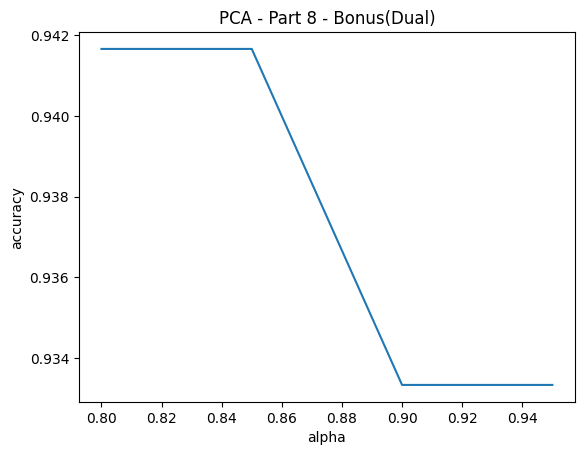

In [32]:
# plotting the points 
plt.plot(alpha_list, accuracy_results_dual)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('PCA - Part 8 - Bonus(Dual)')
plt.show() 